In [9]:
import torch
from d2l import torch as d2l
from IPython import display

batch_size = 256
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size)

In [10]:
num_inputs = 784
num_outputs = 10

W = torch.normal(0, 0.01, size=(num_inputs, num_outputs), requires_grad=True)
b = torch.zeros(num_outputs, requires_grad=True)

$$\mathrm{softmax}(\mathbf{X})_{ij} = \frac{\exp(\mathbf{X}_{ij})}{\sum_k \exp(\mathbf{X}_{ik})}.$$

In [11]:
def softmax(X):
    X_exp = torch.exp(X)
    partition = X_exp.sum(1, keepdim=True)
    return X_exp / partition

In [12]:
def net(X):
    return softmax(torch.matmul(X.reshape(-1, W.shape[0]), W) + b)

$$H(p,q)=\sum_{i}^{} -p_{i} log(q_{i})$$

In [23]:
def cross_entropy(y_hat, y):
    print(y_hat, y)
    return -torch.log(y_hat[range(len(y_hat)), y])

# a = torch.arange(8).reshape(2, 4)
# b = torch.arange(8).reshape(2, 4)
# print(cross_entropy(a, b))

In [22]:
def accuracy(y_hat, y):
    '''计算预测正确的数量'''
    if len(y_hat.shape) > 1 and y_hat.shape[1] > 1:
        y_hat = y_hat.argmax(axis=1)
    cmp = y_hat.type(y.dtype) == y
    return float(cmp.type(y.dtype).sum())

In [15]:
def evaluate_accuracy(net, data_iter):
    if isinstance(net, torch.nn.Module):
        net.eval()
    metric = Accumulator(2)
    for X, y in data_iter:
        metric.add(accuracy(net(X), y), y.numel())
    print('test set', metric[0], metric[1])
    return metric[0] / metric[1]

In [16]:
class Accumulator:
    def __init__(self, n):
        self.data = [0.0] * n
        
    def add(self, *args):
        self.data = [a + float(b) for a, b in zip(self.data, args)]
        
    def reset(self):
        self.data = [0.0] * len(self.data)
        
    def __getitem__(self, idx):
        return self.data[idx]
evaluate_accuracy(net, test_iter)

test set 1078.0 10000.0


0.1078

### softmax回归训练

In [17]:
def train_epoch_ch3(net, train_iter, loss, updater):
    if isinstance(net, torch.nn.Module):
        net.train()
    metric = Accumulator(3)
    for X, y in train_iter:
        y_hat = net(X)
        l = loss(y_hat, y)
        if isinstance(updater, torch.optim.Optimizer):
            updater.zero_grad()
            l.backward()
            updater.step()
            metric.add(float(l) * len(y), accuracy(y_hat, y), y.size().numel())
        else:
            l.sum().backward()
            updater(X.shape[0])
            metric.add(float(l.sum()), accuracy(y_hat, y), y.numel())
    print('train set', metric[0], metric[1], metric[2])
    return metric[0] / metric[2], metric[1] / metric[2]

In [18]:
class Animator:
    def __init__(self, xlabel=None, ylabel=None, legend=None,
                 xlim=None, ylim=None, xscale="linear", yscale='linear',
                fmts=('-', 'm--', 'g-.', 'r:'), nrows=1, ncols=1, figsize=(3.5, 2.5)):
        if legend is None:
            legend = []
        d2l.use_svg_display()
        self.fig, self.axes = d2l.plt.subplots(nrows, ncols, figsize=figsize)
        if nrows * ncols == 1:
            self.axes = [self.axes, ]
            self.config_axes = lambda: d2l.set_axes(self.axes[0], xlabel, ylabel, xlim, ylim, xscale, yscale, legend)
            self.X, self.Y, self.fmts = None, None, fmts
            
    def add(self, x, y):
        if not hasattr(y, '__len__'):
            y = [y]
        n = len(y)
        if not hasattr(x, '__len__'):
            x = [x] * n
        if not self.X:
            self.X = [[] for _ in range(n)]
        if not self.Y:
            self.Y = [[] for _ in range(n)]
        for i, (a, b) in enumerate(zip(x, y)):
            if a is not None and b is not None:
                self.X[i].append(a)
                self.Y[i].append(b)
        self.axes[0].cla()
        for x, y, fmt in zip(self.X, self.Y, self.fmts):
            self.axes[0].plot(x, y, fmt)
        self.config_axes()
        display.display(self.fig)
#         display.clear_output(wait=True)
        

In [19]:
def train_ch3(net, train_iter, test_iter, loss, num_epochs, updater):
    '''train a model'''
    animator = Animator(xlabel='epoch', xlim=[1, num_epochs], ylim=[0.3, 0.9],
                      legend=['train loss', 'train acc', 'test acc'])
    for epoch in range(num_epochs):
        train_metrics = train_epoch_ch3(net, train_iter, loss, updater)
        test_acc = evaluate_accuracy(net, test_iter)
        animator.add(epoch + 1, train_metrics + (test_acc, ))
        train_loss, train_acc = train_metrics
#         assert train_loss < 0.5, train_loss
#         assert train_acc <= 1 and train_acc > 0.1, train_acc
#         assert train_acc <= 1 and test_acc > 0.7, test_acc

In [20]:
lr = 0.1
def updater(batch_size):
    return d2l.sgd([W, b], lr, batch_size)

tensor([[9.8910e-01, 1.9179e-05, 3.9492e-04,  ..., 7.1582e-09, 8.1903e-06,
         3.8937e-07],
        [3.4017e-04, 9.9708e-01, 2.1446e-04,  ..., 5.7177e-06, 8.8830e-06,
         6.2082e-06],
        [6.7698e-03, 1.4769e-03, 5.3439e-01,  ..., 8.1727e-06, 5.8521e-03,
         3.4916e-05],
        ...,
        [3.3412e-06, 1.3330e-06, 2.8215e-05,  ..., 5.0410e-01, 1.3150e-02,
         4.4099e-01],
        [2.8013e-04, 3.5242e-04, 7.7212e-04,  ..., 5.1546e-01, 5.1854e-02,
         6.2381e-02],
        [5.1995e-04, 9.9609e-01, 1.7132e-04,  ..., 1.0689e-06, 4.3599e-07,
         1.5729e-06]], grad_fn=<DivBackward0>) tensor([0, 1, 4, 7, 5, 1, 3, 1, 4, 5, 6, 8, 9, 9, 6, 6, 3, 9, 7, 9, 9, 5, 3, 4,
        4, 6, 9, 9, 0, 7, 7, 0, 7, 3, 9, 5, 9, 4, 6, 1, 1, 7, 7, 9, 5, 7, 6, 6,
        1, 6, 3, 8, 1, 0, 5, 3, 1, 5, 2, 0, 9, 2, 6, 4, 8, 6, 3, 4, 4, 4, 3, 1,
        3, 4, 9, 7, 9, 5, 0, 8, 3, 0, 0, 3, 4, 6, 7, 3, 0, 3, 8, 3, 3, 7, 7, 2,
        5, 9, 3, 9, 5, 7, 5, 0, 1, 2, 1, 4, 9, 3, 6, 9, 4, 7

tensor([[1.6732e-03, 7.2750e-04, 1.5546e-03,  ..., 3.7793e-02, 7.7023e-03,
         1.2120e-01],
        [1.3229e-03, 1.2487e-03, 1.5480e-01,  ..., 1.2804e-06, 2.2468e-03,
         7.8386e-06],
        [6.4366e-03, 3.5023e-04, 5.2157e-01,  ..., 2.5108e-06, 1.0375e-02,
         7.4977e-05],
        ...,
        [1.2450e-04, 3.7649e-05, 1.7524e-04,  ..., 1.0472e-03, 4.7050e-04,
         8.8560e-01],
        [5.6419e-04, 2.1559e-04, 9.4534e-02,  ..., 1.8742e-06, 3.3330e-03,
         1.0878e-05],
        [1.8351e-02, 8.6073e-02, 1.9198e-02,  ..., 1.1574e-03, 1.6223e-04,
         6.7085e-03]], grad_fn=<DivBackward0>) tensor([5, 4, 2, 1, 1, 0, 3, 4, 4, 3, 9, 6, 3, 5, 8, 8, 9, 2, 0, 8, 0, 5, 7, 3,
        7, 5, 4, 8, 4, 3, 7, 3, 0, 1, 8, 3, 5, 6, 7, 2, 0, 7, 2, 5, 8, 3, 2, 5,
        0, 6, 2, 8, 7, 5, 1, 8, 2, 5, 8, 8, 2, 9, 0, 5, 5, 1, 5, 1, 1, 7, 3, 3,
        3, 6, 8, 8, 6, 8, 1, 2, 0, 9, 0, 8, 7, 5, 7, 9, 0, 1, 5, 4, 5, 8, 0, 9,
        0, 5, 3, 4, 3, 9, 4, 4, 2, 0, 5, 7, 3, 5, 2, 6, 5, 4

tensor([[2.5652e-04, 3.3379e-04, 1.7437e-03,  ..., 3.8523e-01, 2.2137e-02,
         4.3709e-02],
        [5.7865e-03, 9.4240e-02, 5.1177e-01,  ..., 2.5911e-04, 1.0201e-03,
         1.4320e-03],
        [4.1152e-01, 4.8639e-03, 1.8555e-02,  ..., 9.6380e-04, 7.9734e-02,
         2.3595e-03],
        ...,
        [8.6137e-01, 5.1265e-03, 4.5347e-02,  ..., 1.7206e-05, 3.4958e-03,
         4.4983e-05],
        [3.9712e-05, 6.6275e-05, 2.4952e-04,  ..., 2.4663e-01, 1.3663e-02,
         2.2724e-01],
        [2.8893e-04, 4.1591e-04, 7.6635e-04,  ..., 6.1467e-01, 2.8370e-02,
         2.0707e-02]], grad_fn=<DivBackward0>) tensor([5, 6, 6, 9, 1, 8, 5, 9, 4, 6, 6, 4, 7, 6, 9, 0, 7, 8, 5, 5, 8, 8, 0, 8,
        8, 8, 5, 5, 5, 8, 0, 9, 0, 3, 1, 9, 7, 0, 2, 9, 1, 6, 4, 3, 4, 3, 2, 4,
        7, 6, 6, 8, 0, 1, 4, 4, 9, 5, 2, 5, 0, 7, 9, 8, 9, 1, 1, 5, 9, 9, 7, 6,
        6, 4, 1, 8, 8, 0, 6, 8, 7, 9, 8, 7, 2, 0, 1, 5, 1, 4, 6, 0, 4, 3, 3, 9,
        1, 2, 8, 7, 2, 7, 0, 0, 3, 6, 6, 5, 8, 6, 4, 2, 0, 2

tensor([[1.5301e-02, 1.3090e-03, 1.9201e-01,  ..., 1.2866e-05, 6.5647e-02,
         3.2675e-05],
        [3.6497e-05, 4.8206e-05, 8.2806e-05,  ..., 3.7004e-01, 4.1802e-03,
         3.7085e-01],
        [4.7424e-04, 3.7751e-04, 1.1229e-03,  ..., 4.3498e-01, 5.3100e-02,
         2.4117e-02],
        ...,
        [2.4464e-02, 2.6734e-03, 7.5211e-01,  ..., 1.6200e-05, 5.8447e-03,
         1.4957e-04],
        [3.2893e-04, 8.4277e-04, 6.6838e-04,  ..., 9.1640e-01, 5.2439e-03,
         1.0072e-02],
        [4.0410e-05, 1.5356e-05, 1.5547e-04,  ..., 1.1617e-01, 9.8990e-03,
         8.4669e-01]], grad_fn=<DivBackward0>) tensor([0, 9, 5, 5, 6, 9, 7, 3, 5, 8, 2, 3, 8, 0, 5, 4, 5, 9, 6, 1, 4, 3, 6, 3,
        3, 1, 0, 8, 5, 3, 5, 4, 3, 6, 5, 4, 2, 3, 3, 7, 5, 3, 0, 9, 5, 3, 3, 5,
        0, 1, 8, 2, 3, 2, 6, 8, 8, 9, 9, 2, 7, 4, 8, 6, 1, 5, 9, 3, 0, 2, 7, 3,
        3, 0, 8, 8, 6, 9, 6, 1, 2, 3, 5, 0, 3, 0, 4, 5, 4, 8, 7, 1, 3, 1, 4, 5,
        3, 0, 3, 9, 2, 0, 5, 2, 6, 8, 7, 6, 2, 2, 9, 8, 4, 8

tensor([[8.1379e-02, 7.6846e-03, 7.4772e-03,  ..., 1.7794e-05, 1.4643e-04,
         5.5447e-05],
        [1.5369e-04, 5.7728e-05, 7.5588e-04,  ..., 2.2707e-01, 1.9500e-02,
         6.8004e-01],
        [4.4226e-06, 2.1560e-06, 1.4969e-05,  ..., 2.1159e-02, 3.7775e-04,
         9.7494e-01],
        ...,
        [2.0324e-06, 6.4765e-07, 2.9430e-04,  ..., 1.7566e-04, 9.9598e-01,
         2.0036e-05],
        [9.3567e-01, 2.1003e-04, 7.4154e-03,  ..., 1.7199e-07, 4.4056e-05,
         4.8162e-06],
        [2.0502e-02, 5.3216e-02, 1.6915e-03,  ..., 3.6591e-05, 5.3791e-04,
         7.0027e-05]], grad_fn=<DivBackward0>) tensor([3, 9, 9, 0, 8, 8, 9, 8, 4, 5, 5, 5, 7, 7, 1, 5, 1, 5, 4, 0, 1, 9, 8, 1,
        9, 0, 4, 2, 9, 1, 5, 7, 9, 1, 0, 6, 7, 2, 6, 4, 3, 5, 3, 6, 5, 6, 9, 1,
        2, 7, 5, 6, 5, 0, 7, 0, 6, 1, 9, 5, 0, 7, 7, 7, 5, 7, 7, 4, 4, 8, 6, 1,
        0, 2, 6, 6, 2, 4, 8, 8, 9, 6, 2, 2, 9, 9, 2, 9, 9, 2, 3, 9, 4, 2, 5, 4,
        3, 0, 8, 7, 9, 0, 3, 5, 4, 8, 4, 1, 9, 1, 5, 2, 7, 4

tensor([[2.1171e-01, 8.5342e-02, 3.6485e-02,  ..., 8.5279e-03, 1.0171e-01,
         6.2520e-03],
        [9.6770e-01, 1.8076e-04, 2.4918e-03,  ..., 1.1637e-07, 1.4057e-05,
         2.1471e-06],
        [3.8198e-05, 3.5809e-05, 3.0902e-04,  ..., 6.4295e-01, 1.0416e-01,
         6.4161e-02],
        ...,
        [6.7267e-07, 4.1103e-07, 2.4531e-05,  ..., 9.5134e-05, 4.6126e-04,
         2.7785e-03],
        [7.4153e-04, 4.0169e-05, 1.1891e-03,  ..., 5.3761e-04, 9.9334e-01,
         1.2471e-03],
        [2.3460e-02, 7.8513e-03, 1.1648e-03,  ..., 4.6315e-04, 7.3634e-03,
         7.9002e-04]], grad_fn=<DivBackward0>) tensor([3, 0, 7, 4, 8, 2, 3, 7, 6, 4, 5, 6, 0, 3, 7, 0, 3, 1, 3, 4, 2, 6, 4, 2,
        9, 9, 8, 3, 2, 8, 2, 1, 7, 3, 4, 8, 0, 1, 4, 9, 6, 7, 6, 9, 3, 0, 9, 6,
        5, 2, 4, 8, 0, 5, 1, 8, 5, 5, 3, 9, 6, 8, 9, 7, 9, 4, 0, 9, 4, 2, 4, 6,
        8, 1, 4, 4, 8, 1, 7, 1, 5, 4, 2, 2, 3, 3, 8, 2, 9, 4, 6, 9, 3, 5, 7, 5,
        3, 2, 1, 6, 2, 6, 5, 8, 6, 9, 6, 6, 8, 1, 4, 9, 8, 9

tensor([[2.3341e-02, 3.9063e-02, 2.2653e-02,  ..., 1.9013e-04, 7.8867e-04,
         2.9497e-04],
        [1.5262e-02, 2.4464e-02, 2.1625e-03,  ..., 7.5139e-05, 2.4353e-04,
         6.0852e-05],
        [8.7506e-04, 1.6902e-03, 2.0991e-03,  ..., 3.6656e-05, 1.0926e-04,
         2.9450e-05],
        ...,
        [5.5400e-01, 4.1626e-02, 1.4299e-02,  ..., 8.0639e-05, 3.9041e-03,
         4.5543e-05],
        [1.5159e-04, 3.7980e-04, 3.2021e-04,  ..., 9.8399e-01, 3.9108e-03,
         1.9800e-03],
        [1.2501e-05, 2.2578e-05, 5.3365e-05,  ..., 9.7723e-01, 1.9158e-03,
         9.2012e-04]], grad_fn=<DivBackward0>) tensor([4, 4, 4, 3, 3, 2, 3, 9, 5, 7, 6, 0, 4, 3, 6, 7, 3, 6, 7, 5, 0, 3, 4, 1,
        4, 7, 4, 7, 5, 1, 7, 0, 8, 7, 3, 2, 3, 4, 6, 2, 3, 3, 6, 4, 2, 1, 9, 0,
        0, 4, 8, 8, 8, 7, 4, 9, 6, 7, 0, 1, 1, 4, 1, 3, 1, 5, 9, 3, 8, 7, 0, 7,
        0, 6, 1, 6, 2, 1, 7, 7, 1, 9, 6, 6, 6, 7, 3, 3, 8, 2, 9, 7, 5, 0, 3, 8,
        6, 6, 6, 4, 8, 0, 7, 6, 5, 9, 9, 0, 4, 4, 5, 0, 1, 0

tensor([[2.1494e-03, 1.2005e-03, 2.1222e-03,  ..., 4.4048e-01, 1.9125e-02,
         4.7582e-01],
        [9.7976e-02, 8.4910e-03, 3.1760e-01,  ..., 1.5842e-03, 1.6378e-01,
         7.5185e-03],
        [1.2607e-04, 9.9949e-01, 2.8442e-05,  ..., 1.1295e-07, 3.9164e-07,
         3.4715e-08],
        ...,
        [4.3092e-04, 4.9635e-04, 1.1566e-03,  ..., 4.0844e-02, 5.4984e-03,
         3.0697e-03],
        [4.2034e-02, 2.8461e-02, 1.0032e-01,  ..., 8.8864e-04, 7.3421e-03,
         1.1634e-03],
        [2.1431e-03, 2.5928e-03, 3.6420e-03,  ..., 6.0805e-01, 4.0562e-02,
         8.1456e-02]], grad_fn=<DivBackward0>) tensor([7, 4, 1, 1, 9, 9, 4, 1, 4, 9, 7, 3, 0, 2, 1, 0, 6, 2, 3, 6, 6, 6, 3, 0,
        4, 0, 9, 3, 1, 5, 1, 7, 3, 3, 2, 4, 8, 3, 2, 9, 9, 8, 8, 9, 9, 8, 3, 9,
        8, 0, 4, 6, 2, 5, 5, 7, 0, 1, 6, 7, 8, 5, 9, 7, 3, 3, 7, 1, 1, 2, 4, 4,
        2, 8, 5, 5, 2, 5, 2, 7, 5, 3, 3, 2, 7, 5, 3, 3, 9, 9, 5, 3, 7, 4, 5, 2,
        6, 4, 7, 8, 4, 9, 1, 9, 8, 2, 1, 8, 9, 8, 8, 6, 5, 3

tensor([[3.5686e-01, 7.0829e-03, 1.4136e-01,  ..., 2.1065e-04, 6.1182e-02,
         1.2495e-03],
        [1.7746e-05, 2.9778e-06, 5.1798e-06,  ..., 1.6990e-02, 1.7254e-04,
         9.7045e-01],
        [1.2855e-02, 3.2833e-03, 4.2282e-02,  ..., 1.8229e-02, 6.9748e-01,
         1.3888e-02],
        ...,
        [6.3636e-03, 5.6739e-04, 3.3673e-03,  ..., 1.5329e-02, 2.5326e-01,
         2.4011e-01],
        [4.8012e-03, 3.7686e-04, 4.3348e-03,  ..., 1.6823e-03, 9.5507e-01,
         5.8853e-03],
        [1.5760e-01, 5.4675e-02, 4.2834e-02,  ..., 3.3017e-03, 1.1879e-02,
         2.9620e-03]], grad_fn=<DivBackward0>) tensor([2, 9, 8, 3, 9, 9, 3, 9, 0, 8, 0, 3, 0, 3, 0, 6, 4, 3, 9, 8, 4, 1, 7, 1,
        8, 4, 9, 3, 8, 6, 2, 2, 9, 2, 0, 8, 4, 6, 9, 8, 0, 4, 7, 8, 6, 1, 7, 6,
        1, 2, 2, 2, 5, 0, 7, 3, 8, 1, 2, 6, 8, 3, 8, 4, 9, 6, 8, 1, 3, 0, 9, 0,
        6, 8, 8, 3, 8, 1, 3, 5, 3, 2, 5, 0, 3, 7, 5, 1, 5, 3, 9, 5, 9, 4, 9, 4,
        3, 6, 1, 4, 6, 4, 9, 9, 2, 8, 8, 4, 9, 1, 6, 9, 1, 0

tensor([[2.0380e-01, 2.1185e-02, 1.5987e-01,  ..., 1.8861e-03, 4.3530e-02,
         2.1737e-03],
        [2.7351e-03, 9.7793e-01, 2.9401e-03,  ..., 3.0236e-04, 1.6419e-04,
         3.2823e-04],
        [5.5626e-03, 8.1229e-03, 3.4083e-01,  ..., 3.1827e-04, 9.8762e-03,
         6.3712e-04],
        ...,
        [3.2454e-03, 4.6868e-03, 4.7591e-03,  ..., 5.4422e-01, 1.4029e-02,
         1.9069e-01],
        [1.1645e-01, 1.6610e-03, 1.6086e-01,  ..., 5.6092e-05, 3.1463e-01,
         4.9817e-04],
        [8.7934e-06, 1.0408e-05, 9.4986e-05,  ..., 1.3377e-03, 2.3156e-03,
         1.7698e-02]], grad_fn=<DivBackward0>) tensor([3, 1, 4, 3, 3, 5, 2, 2, 9, 4, 9, 6, 1, 1, 7, 1, 5, 7, 0, 2, 7, 7, 3, 7,
        3, 5, 2, 2, 4, 3, 7, 4, 9, 9, 4, 6, 8, 7, 2, 4, 0, 0, 2, 0, 7, 7, 7, 4,
        1, 3, 1, 1, 2, 1, 2, 9, 1, 3, 9, 3, 6, 5, 5, 3, 7, 1, 0, 9, 6, 7, 2, 6,
        9, 3, 0, 1, 8, 8, 3, 1, 0, 7, 2, 6, 5, 3, 6, 0, 2, 5, 4, 6, 5, 2, 2, 4,
        9, 9, 8, 8, 9, 6, 3, 4, 3, 1, 1, 4, 9, 4, 8, 4, 8, 6

tensor([[3.3928e-02, 9.3003e-01, 3.9641e-03,  ..., 7.6347e-04, 1.9249e-03,
         4.1025e-04],
        [5.5880e-01, 2.0115e-03, 5.3508e-03,  ..., 9.2643e-05, 3.0595e-02,
         9.1345e-05],
        [2.5064e-03, 2.0599e-02, 2.0309e-03,  ..., 7.9120e-06, 6.2371e-06,
         2.9191e-05],
        ...,
        [1.3801e-01, 7.1166e-03, 1.9248e-01,  ..., 4.0059e-05, 6.6160e-03,
         9.1223e-05],
        [7.4495e-05, 9.9941e-01, 2.8959e-05,  ..., 1.2249e-06, 5.1602e-07,
         1.2099e-06],
        [3.6075e-03, 9.3901e-01, 2.3415e-03,  ..., 8.8183e-05, 8.9781e-05,
         1.4814e-04]], grad_fn=<DivBackward0>) tensor([1, 0, 3, 8, 6, 3, 4, 7, 9, 4, 7, 3, 0, 1, 4, 4, 6, 7, 2, 8, 7, 6, 8, 6,
        9, 6, 7, 2, 0, 8, 2, 1, 8, 6, 7, 7, 5, 2, 2, 3, 4, 0, 9, 1, 0, 1, 7, 8,
        6, 4, 1, 0, 5, 0, 9, 8, 1, 4, 4, 4, 5, 4, 4, 3, 7, 2, 1, 3, 8, 6, 7, 3,
        5, 6, 0, 2, 4, 8, 6, 6, 3, 6, 5, 5, 5, 7, 3, 2, 3, 3, 8, 9, 5, 5, 6, 1,
        1, 9, 3, 8, 7, 0, 4, 1, 5, 7, 9, 0, 5, 2, 5, 3, 1, 0

tensor([[1.9437e-06, 8.8382e-06, 3.7045e-04,  ..., 2.6979e-03, 9.9345e-01,
         6.2723e-04],
        [5.9619e-03, 3.2839e-02, 5.3642e-01,  ..., 9.6159e-05, 5.2224e-04,
         4.3963e-04],
        [4.1728e-02, 1.2098e-02, 1.3839e-01,  ..., 2.6867e-03, 4.8511e-02,
         2.3371e-03],
        ...,
        [3.2956e-04, 1.0611e-04, 1.1068e-03,  ..., 5.5660e-03, 5.0933e-03,
         2.6760e-02],
        [4.2558e-04, 8.9557e-04, 2.5145e-03,  ..., 2.0030e-01, 5.4919e-02,
         1.5157e-02],
        [2.3597e-02, 4.1835e-03, 4.1178e-02,  ..., 3.3208e-03, 8.0954e-01,
         1.7131e-03]], grad_fn=<DivBackward0>) tensor([8, 2, 6, 8, 9, 1, 0, 7, 4, 8, 3, 7, 5, 8, 8, 6, 6, 7, 1, 6, 9, 7, 0, 6,
        4, 3, 4, 5, 2, 7, 5, 8, 8, 6, 5, 7, 5, 5, 8, 4, 2, 2, 5, 2, 8, 3, 5, 6,
        3, 4, 3, 1, 0, 0, 8, 3, 4, 1, 4, 4, 1, 3, 7, 8, 3, 1, 0, 1, 3, 0, 2, 6,
        8, 7, 8, 7, 2, 2, 4, 4, 3, 4, 5, 4, 7, 6, 0, 8, 5, 1, 5, 6, 5, 1, 4, 2,
        8, 0, 1, 0, 0, 0, 4, 5, 9, 0, 5, 0, 7, 4, 2, 2, 9, 5

KeyboardInterrupt: 

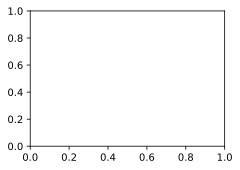

In [24]:
num_epochs = 10
train_ch3(net, train_iter, test_iter, cross_entropy, num_epochs, updater)